# Decision Tree Model with One Hot Encoder for Categorical Variables

- State space search for meta parameter tuning across `min_samples_split` and `min_samples_leaf`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import pandas
import numpy
import itertools
import matplotlib.pyplot as plt
import sklearn
from sklearn import tree
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import CategoricalNB

In [3]:
import loan_approval_lib
from loan_approval_lib import logspace, linspace

In [4]:
from loan_approval_lib.standard_data_processing import data_cleaning_algorithm
from loan_approval_lib.standard_data_processing import create_loan_grade_numerical_from_loan_grade
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_person_home_ownership_one_hot
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot_encoder
from loan_approval_lib.standard_data_processing import create_loan_intent_one_hot
from loan_approval_lib.standard_data_processing import map_cb_person_default_on_file
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id
from loan_approval_lib.standard_data_processing import create_dataframe_copy_and_drop_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns
from loan_approval_lib.standard_data_processing import create_decision_tree_columns_with_id

In [5]:
data = loan_approval_lib.load_original_data()

In [6]:
data_train = loan_approval_lib.load_data_train()

In [7]:
data_test = loan_approval_lib.load_data_test()

# Data Cleaning

In [8]:
data = data_cleaning_algorithm(data)

column person_age, number of removed rows: 5
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 897
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 3047
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [9]:
data_train = data_cleaning_algorithm(data_train)

column person_age, number of removed rows: 1
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 2
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [10]:
data_cleaning_algorithm(data_test)
None

column person_age, number of removed rows: 0
column person_income, number of removed rows: 0
column person_emp_length, number of removed rows: 0
column loan_amnt, number of removed rows: 0
column loan_int_rate, number of removed rows: 0
column loan_percent_income, number of removed rows: 0
column cb_person_default_on_file, number of removed rows: 0


In [11]:
# Loan Grade

create_loan_grade_numerical_from_loan_grade(data, data_train, data_test)

In [12]:
# Person Home Ownership

encoder = create_person_home_ownership_one_hot_encoder(data)

data = create_person_home_ownership_one_hot(encoder, data)
data_train = create_person_home_ownership_one_hot(encoder, data_train)
data_test = create_person_home_ownership_one_hot(encoder, data_test)

In [13]:
# Loan Intent

encoder = create_loan_intent_one_hot_encoder(data)

data = create_loan_intent_one_hot(encoder, data)
data_train = create_loan_intent_one_hot(encoder, data_train)
data_test = create_loan_intent_one_hot(encoder, data_test)

In [14]:
# Default On File

data = map_cb_person_default_on_file(data)
data_train = map_cb_person_default_on_file(data_train)
data_test = map_cb_person_default_on_file(data_test)

# Choose Columns for Tree Model, Copy DataFrame and Drop Unused Columns

In [15]:
decision_tree_columns = create_decision_tree_columns()
decision_tree_columns_with_id = create_decision_tree_columns_with_id()

In [16]:
data_copy = create_dataframe_copy_and_drop_columns(data)
data_train_copy = create_dataframe_copy_and_drop_columns(data_train)
data_test_copy = create_dataframe_copy_and_drop_columns(data_test)

# Optimize Choice of Dataset

In [17]:
all_training_data = pandas.concat(
    [data_copy, data_train_copy],
    axis=0,
)
all_training_data.reset_index(inplace=True, drop=True)

In [18]:
permutation = numpy.random.permutation(all_training_data.index)

In [19]:
n_samples = len(all_training_data)
n_samples

87274

In [20]:
k = 100

In [21]:
fold_sizes = numpy.full(k, n_samples // k, dtype=int)
fold_sizes

array([872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [22]:
fold_sizes[:n_samples % k] += 1
fold_sizes

array([873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873, 873,
       873, 873, 873, 873, 873, 873, 873, 873, 873, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872, 872,
       872, 872, 872, 872, 872, 872, 872, 872, 872])

In [23]:
index = 0
folds = []
for fold_size in fold_sizes:
    start = index
    stop = index + fold_size
    folds.append(permutation[start:stop])
    index = stop

# Decision Tree Model

In [24]:
def decision_tree_model_train(
    data_train,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
):
    
    X = data_train[decision_tree_columns].copy()
    Y = data_train['loan_status'].copy()
    
    clf = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=None,
        max_leaf_nodes=max_leaf_nodes,
        min_impurity_decrease=min_impurity_decrease,
    )
    clf = clf.fit(X, Y)

    feature_importances = pandas.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
    feature_importances = feature_importances[feature_importances > 0]

    Z = clf.predict(X)
    X['loan_status_predict'] = Z
    X['loan_status'] = data_train['loan_status']
    accuracy_in_sample = (X['loan_status'] == X['loan_status_predict']).sum() / len(X)

    return (clf, feature_importances, accuracy_in_sample)

In [25]:
def decision_tree_model_test(
    clf,
    data_test,
    decision_tree_columns,
):

    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict(X_test)
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy_out_of_sample = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy_out_of_sample

In [26]:
def decision_tree_model_predict_proba(
    clf,
    data_test,
    decision_tree_columns,
):
    
    X_test = data_test[decision_tree_columns].copy()
    
    Z_test = clf.predict_proba(X_test)[:, 1]

    return Z_test

In [27]:
def decision_tree_model_test_threshold(
    clf,
    data_test,
    decision_tree_columns,
    threshold,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = (clf.predict_proba(X_test)[:, 1]) > threshold
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']
    accuracy = (X_test['loan_status'] == X_test['loan_status_predict']).sum() / len(X_test)
    
    return accuracy

In [28]:
def decision_tree_model_test_TPR_FPR(
    clf,
    data_test,
    decision_tree_columns,
    threshold,
):

    X_test = data_test[decision_tree_columns].copy()

    Z_test = (clf.predict_proba(X_test)[:, 1]) > threshold
    X_test['loan_status_predict'] = Z_test
    X_test['loan_status'] = data_test['loan_status']

    true_positive  = len(X_test[(X_test['loan_status'] == 1) & (X_test['loan_status_predict'] == 1)]) # positive, same -> true
    false_positive = len(X_test[(X_test['loan_status'] == 0) & (X_test['loan_status_predict'] == 1)]) # positive, different -> false
    true_negative  = len(X_test[(X_test['loan_status'] == 0) & (X_test['loan_status_predict'] == 0)]) # negative, same -> true
    false_negative = len(X_test[(X_test['loan_status'] == 1) & (X_test['loan_status_predict'] == 0)]) # negative, different -> false

    tpr = true_positive / (true_positive + false_negative)
    fpr = false_positive / (false_positive + true_negative)

    return (tpr, fpr)

In [29]:
def decision_tree_model_test_AUC(
    clf,
    data_test,
    decision_tree_columns,
):
    # create threshold array
    # this code creates `threshold_array`, and it is sorted in ascending order
    
    data_predict = decision_tree_model_predict(
        clf,
        data_test,
        decision_tree_columns,
        decision_tree_columns_with_id,
    )
    
    threshold_array = numpy.concatenate(
        (
            numpy.array([-numpy.inf]),
            numpy.unique(data_predict['loan_status']),
            numpy.array([1.1]),
        )
    )

    # use threshold array to calculate TPR and FPR
    count = len(threshold_array)

    tpr_array = numpy.zeros(shape=(count,), dtype=float)
    fpr_array = numpy.zeros(shape=(count,), dtype=float)
    
    for i, threshold in enumerate(threshold_array):
        (tpr, fpr) = decision_tree_model_test_TPR_FPR(
            clf,
            test_data,
            decision_tree_columns,
            threshold,
        )
    
        threshold_array[i] = threshold
        tpr_array[i] = tpr
        fpr_array[i] = fpr
    
    sort_index = numpy.argsort(fpr_array)
    tpr_array = tpr_array[sort_index]
    fpr_array = fpr_array[sort_index]
    threshold_array = threshold_array[sort_index]

    # calculate threshold array, TPR and FPR
    # (roc_curve_fpr, roc_curve_tpr, roc_curve_threshold) = roc_curve(
    #     test_data['loan_status'],
    #     decision_tree_model_predict_proba(clf, test_data, decision_tree_columns),
    # )
    # may not include the -inf and +inf bounds?

    # use TPR and FPR to calculate AUC
    roc_auc = auc(fpr_array, tpr_array)
    #roc_auc = auc(roc_curve_fpr, roc_curve_tpr)
    
    return roc_auc

In [30]:
def decision_tree_model_predict(
    clf,
    data_predict,
    decision_tree_columns,
    decision_tree_columns_with_id,
):
    
    X_predict = data_predict[decision_tree_columns_with_id].copy()

    Z_predict = clf.predict_proba(X_predict[decision_tree_columns])
    X_predict['loan_status'] = Z_predict[:, 1]

    return X_predict

In [31]:
def decision_tree_model_predict_write_to_csv(
    data_predict,
    filename,
):
    data_predict[['id', 'loan_status']].to_csv(filename, index=False)

# Optimize on all data - produce ROC curve

- Train original good performing model, min samples split 30, min samples leaf 4
- Train using slightly worse model where max depth was optimized to 100

In [32]:
# train with everything

max_depth = None #100
min_samples_split = 30 #2
max_leaf_nodes = None
min_samples_leaf = 4 #1
min_impurity_decrease = 0.0

i = 0

test_index = folds[i]
train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
            
training_data = all_training_data.loc[train_index]
test_data = all_training_data.loc[test_index]

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

(tpr, fpr) = decision_tree_model_test_TPR_FPR(
    clf,
    test_data,
    decision_tree_columns,
    0.5,
)

# data_predict = decision_tree_model_predict(
#     clf,
#     data_test_copy,
#     decision_tree_columns,
#     decision_tree_columns_with_id,
# )

#decision_tree_model_predict_write_to_csv(
#    data_predict,
#    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_100_all_training_data.csv'
#)

# Plot the distribution of `predict_proba` values

In [33]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

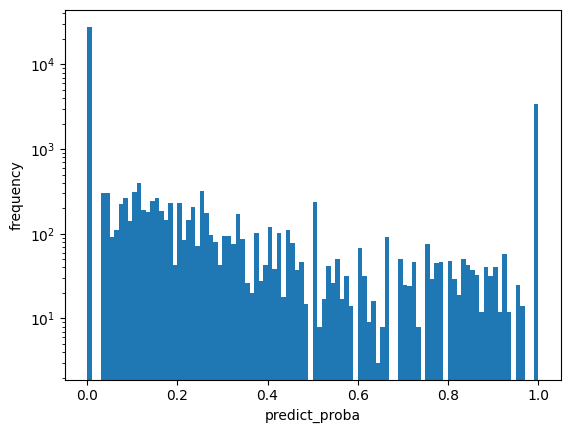

In [34]:
plt.figure()
plt.hist(data_predict['loan_status'], bins=100)
plt.yscale('log')

plt.xlabel('predict_proba')
plt.ylabel('frequency')

None

In [68]:
# this code creates `threshold_array`, and it is sorted in ascending order

data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

threshold_array = numpy.concatenate(
    (
        numpy.array([-numpy.inf]),
        numpy.unique(data_predict['loan_status']),
        numpy.array([1.1]),
    )
)

In [70]:
count = len(threshold_array)

accuracy_array = numpy.zeros(shape=(count,), dtype=float)

for i, threshold in enumerate(threshold_array):
    accuracy = decision_tree_model_test_threshold(
        clf,
        test_data,
        decision_tree_columns,
        threshold,
    )

    threshold_array[i] = threshold
    accuracy_array[i] = accuracy

# Plot Model Accuracy

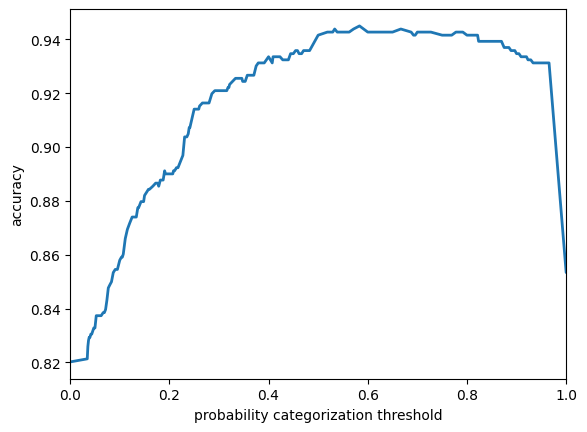

In [73]:
plt.figure()

plt.plot(
    threshold_array,
    accuracy_array,
    linewidth=2,
)

plt.ylabel('accuracy')
plt.xlabel('probability categorization threshold')
plt.xlim(0.0, 1.0)

None

# Plot Model ROC AUC

In [35]:
# todo

# Decision Tree Model - Min Samples Split and Min Samples Leaf State Space Search

In [93]:
max_depth = None
min_samples_split = 2
max_leaf_nodes = None
min_samples_leaf = 1
min_impurity_decrease = 0.0

accuracy_in_sample_list = []
accuracy_out_of_sample_list = []
auc_list = []
max_depth_list = []
min_samples_split_list = []
max_leaf_nodes_list = []
min_samples_leaf_list = []
min_impurity_decrease_list = []

max_depth_list_input = []
min_samples_split_list_input = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900,
                                1000, ]
max_leaf_nodes_list_input = []
min_samples_leaf_list_input = [2, 4, 8, 16, 32, 64, 128, 256, 512]
min_impurity_decrease_list_input = [0.0, 0.001, 0.01, 0.1]

filename = f'decision_tree_model_by_min_samples_split_min_samples_leaf_AUC.csv'

df = None

for min_samples_leaf in min_samples_leaf_list_input:
    for min_samples_split in min_samples_split_list_input:
        print(f'processing min_samples_leaf={min_samples_leaf} min_samples_split={min_samples_split}')
    
        # read data from file
        if df is None:
            try:
                df = pandas.read_csv(filename, index_col=0)
            except:
                pass
    
            if df is not None:
                accuracy_in_sample_list = df['accuracy_in_sample'].to_numpy().tolist()
                accuracy_out_of_sample_list = df['accuracy_out_of_sample'].to_numpy().tolist()
                auc_list = df['auc'].to_numpy().tolist()
                max_depth_list = df['max_depth'].to_numpy().tolist()
                min_samples_split_list = df['min_samples_split'].to_numpy().tolist()
                max_leaf_nodes_list = df['max_leaf_nodes'].to_numpy().tolist()
                min_samples_leaf_list = df['min_samples_leaf'].to_numpy().tolist()
                min_impurity_decrease_list = df['min_impurity_decrease'].to_numpy().tolist()

        if df is not None:
            if len(df[(df['min_samples_leaf'] == min_samples_leaf) & (df['min_samples_split'] == min_samples_split)]) > 0:
                continue
        
        for i in range(k):
            test_index = folds[i]
            train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
                
            training_data = all_training_data.loc[train_index]
            test_data = all_training_data.loc[test_index]
            
            (
                clf,
                feature_importances,
                accuracy_in_sample,
            ) = decision_tree_model_train(
                training_data,
                decision_tree_columns,
                max_depth,
                min_samples_split,
                max_leaf_nodes,
                min_samples_leaf,
                min_impurity_decrease,
            )
            
            accuracy_out_of_sample = decision_tree_model_test(
                clf,
                test_data,
                decision_tree_columns,
            )
    
            auc_ = decision_tree_model_test_AUC(
                clf,
                test_data,
                decision_tree_columns,
            )
        
            accuracy_in_sample_list.append(accuracy_in_sample)
            accuracy_out_of_sample_list.append(accuracy_out_of_sample)
            auc_list.append(auc_)
            max_depth_list.append(max_depth)
            min_samples_split_list.append(min_samples_split)
            max_leaf_nodes_list.append(max_leaf_nodes)
            min_samples_leaf_list.append(min_samples_leaf)
            min_impurity_decrease_list.append(min_impurity_decrease)
            
            #data_predict = decision_tree_model_predict(
            #    clf,
            #    data_test_copy,
            #    decision_tree_columns,
            #    decision_tree_columns_with_id,
            #)
            
            #decision_tree_model_predict_write_to_csv(
            #    data_predict,
            #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-max_depth_none.csv'
            #)
    
        # write data to file
        df = pandas.DataFrame(
            {
                'max_depth': max_depth_list,
                'min_samples_split': min_samples_split_list,
                'max_leaf_nodes': max_leaf_nodes_list,
                'min_samples_leaf': min_samples_leaf_list,
                'min_impurity_decrease': min_impurity_decrease_list,
                'accuracy_in_sample': accuracy_in_sample_list,
                'accuracy_out_of_sample': accuracy_out_of_sample_list,
                'auc': auc_list,
                #'public_score': public_score_list,
                #'private_score': private_score_list,
            }
        )
        df['max_depth'] = df['max_depth'].astype(object)
        df['max_leaf_nodes'] = df['max_leaf_nodes'].astype(object)
        df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
        df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'
        df.to_csv(filename, index=True)

print(f'done')

processing min_samples_leaf=2 min_samples_split=10
processing min_samples_leaf=2 min_samples_split=20
processing min_samples_leaf=2 min_samples_split=30
processing min_samples_leaf=2 min_samples_split=40
processing min_samples_leaf=2 min_samples_split=50
processing min_samples_leaf=2 min_samples_split=60
processing min_samples_leaf=2 min_samples_split=70
processing min_samples_leaf=2 min_samples_split=80
processing min_samples_leaf=2 min_samples_split=90
processing min_samples_leaf=2 min_samples_split=100
processing min_samples_leaf=2 min_samples_split=200
processing min_samples_leaf=2 min_samples_split=300
processing min_samples_leaf=2 min_samples_split=400
processing min_samples_leaf=2 min_samples_split=500
processing min_samples_leaf=2 min_samples_split=600
processing min_samples_leaf=2 min_samples_split=700
processing min_samples_leaf=2 min_samples_split=800
processing min_samples_leaf=2 min_samples_split=900
processing min_samples_leaf=2 min_samples_split=1000
processing min_sampl

In [94]:
df = pandas.DataFrame(
    {
        'max_depth': max_depth_list,
        'min_samples_split': min_samples_split_list,
        'max_leaf_nodes': max_leaf_nodes_list,
        'min_samples_leaf': min_samples_leaf_list,
        'min_impurity_decrease': min_impurity_decrease_list,
        'accuracy_in_sample': accuracy_in_sample_list,
        'accuracy_out_of_sample': accuracy_out_of_sample_list,
        'auc': auc_list,
        #'public_score': public_score_list,
        #'private_score': private_score_list,
    }
)

In [95]:
df.loc[df['max_depth'].isna(), 'max_depth'] = 'none'
df.loc[df['max_leaf_nodes'].isna(), 'max_leaf_nodes'] = 'none'

In [96]:
df

,max_depth,min_samples_split,max_leaf_nodes,min_samples_leaf,min_impurity_decrease,accuracy_in_sample,accuracy_out_of_sample,auc
0,none,10,none,8,0.0,0.955058,0.931271,0.889165
1,none,10,none,8,0.0,0.954908,0.927835,0.903055
2,none,10,none,8,0.0,0.955232,0.935853,0.887407
3,none,10,none,8,0.0,0.955024,0.933562,0.907063
4,none,10,none,8,0.0,0.955417,0.958763,0.927960
...,...,...,...,...,...,...,...,...
17095,none,1000,none,512,0.0,0.933902,0.923165,0.918302
17096,none,1000,none,512,0.0,0.933728,0.940367,0.943343
17097,none,1000,none,512,0.0,0.933856,0.927752,0.922060
17098,none,1000,none,512,0.0,0.933740,0.939220,0.935508


In [119]:
df.loc[df['max_depth'] == 'none', 'max_depth'] = 100 # number of features
df['max_depth'] = df['max_depth'].astype(float)
df['max_depth'] = df['max_depth'].astype(int)

# Aggregate data for line graphs

In [35]:
aggregation_spec = {
    f'{input_column}': [
        (f'{input_column}_mean', 'mean'),
        (f'{input_column}_median', 'median'),
        (f'{input_column}_min', 'min'),
        (f'{input_column}_max', 'max'),
        (f'{input_column}_q1', lambda x: x.quantile(0.25)),
        (f'{input_column}_q3', lambda x: x.quantile(0.75)),
    ]
    for input_column in [
        'accuracy_in_sample',
        'accuracy_out_of_sample',
        'auc',
        #'oob_score',
        #'public_score',
        #'private_score',
    ]
}

In [97]:
df_aggregated = df.groupby(
    by=['max_depth', 'min_samples_split', 'max_leaf_nodes', 'min_samples_leaf', 'min_impurity_decrease']
).aggregate(
    aggregation_spec
)

df_aggregated.columns = [column[1] for column in df_aggregated.columns]

df_aggregated.reset_index(inplace=True)

In [37]:
# TODO: don't think I need this anymore
#df_aggregated.loc[df_aggregated['max_depth'] == 'none', 'max_depth'] = 19 # number of features
#df_aggregated['max_depth'] = df_aggregated['max_depth'].astype(int)

In [98]:
df_aggregated[['min_samples_split', 'min_samples_leaf', 'auc_median']]

,min_samples_split,min_samples_leaf,auc_median
0,10,2,0.882779
1,10,4,0.890950
2,10,8,0.905728
3,10,16,0.915866
4,10,32,0.928712
...,...,...,...
166,1000,32,0.932926
167,1000,64,0.932172
168,1000,128,0.931996
169,1000,256,0.929327


In [105]:
df_aggregated[
    ['min_samples_split', 'min_samples_leaf', 'auc_median']
].sort_values(
    by=['auc_median'],
    ascending=False,
)

,min_samples_split,min_samples_leaf,auc_median
112,400,32,0.936668
111,400,16,0.936471
102,300,16,0.936432
104,300,64,0.936363
113,400,64,0.936247
...,...,...,...
11,20,8,0.905622
10,20,4,0.901247
9,20,2,0.898917
1,10,4,0.890950


# Plot 2d (median)

In [99]:
df_aggregated_sorted = df_aggregated.sort_values(by=['min_samples_leaf', 'min_samples_split'])

x_unique = df_aggregated_sorted['min_samples_split'].unique()
y_unique = df_aggregated_sorted['min_samples_leaf'].unique()

z_grid = df_aggregated_sorted['auc_median'].to_numpy().reshape((len(y_unique), len(x_unique)))

In [100]:
def compute_edges(vals):
    centers = numpy.array(vals)
    edges = numpy.zeros(len(centers) + 1)
    edges[1:-1] = (centers[1:] + centers[:-1]) / 2
    edges[0] = centers[0] - (centers[1] - centers[0]) / 2
    edges[-1] = centers[-1] + (centers[-1] - centers[-2]) / 2
    return edges

In [101]:
x_edges = compute_edges(x_unique)
y_edges = compute_edges(y_unique)

In [102]:
x_edges

array([   5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,
         95.,  150.,  250.,  350.,  450.,  550.,  650.,  750.,  850.,
        950., 1050.])

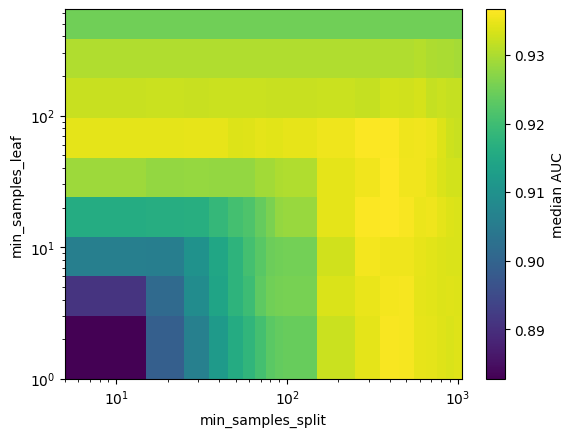

In [150]:
plt.pcolormesh(
    x_edges,
    y_edges,
    z_grid,
    #origin='lower',
    #aspect='auto',
    shading='auto',
    cmap='viridis',
)
plt.xlabel('min_samples_split')
plt.ylabel('min_samples_leaf')
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='median AUC')

plt.savefig('decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-state-space-search.png')
plt.savefig('decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-state-space-search.pdf')

None

# Run model for best parameters - Plot AUC Distribution from k-fold

In [112]:
# make prediction - optimized using 400, 32 best value from state space search
# use kfold validation to produce distribution of AUC values

max_depth = None
min_samples_split = 400
max_leaf_nodes = None
min_samples_leaf = 32
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
    #)
    #
    #auc_

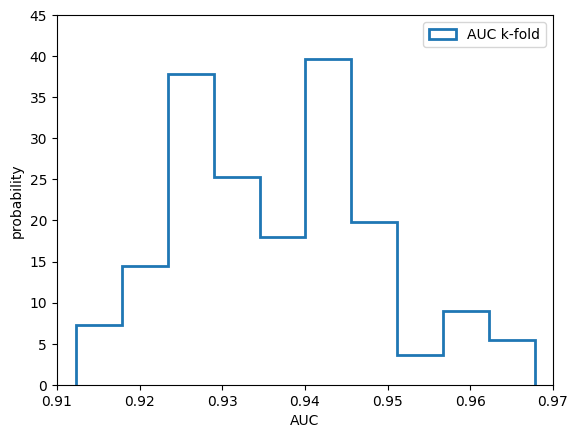

In [152]:
plt.figure()

plt.hist(
    auc_list,
    histtype='step',
    linewidth=2,
    density=True,
    label='AUC k-fold',
)
plt.xlabel('AUC')
plt.ylabel('probability')
plt.xlim(0.91, 0.97)
plt.ylim(0.0, 45)
plt.legend()

plt.savefig('state-space-search-AUC-k-fold.pdf')

None

# Run model for best parameters - Plot ROC

In [124]:
# make prediction - optimized using 400, 32 best value from state space search

max_depth = None
min_samples_split = 400
max_leaf_nodes = None
min_samples_leaf = 32
min_impurity_decrease = 0.0

k = 100
i = 0

test_index = folds[i]
train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])

training_data = all_training_data.loc[train_index]
test_data = all_training_data.loc[test_index]
#training_data = all_training_data
#test_data = all_training_data

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

auc_ = decision_tree_model_test_AUC(
    clf,
    test_data,
    decision_tree_columns,
)

#data_predict = decision_tree_model_predict(
#    clf,
#    data_test_copy,
#    decision_tree_columns,
#    decision_tree_columns_with_id,
#)

#decision_tree_model_predict_write_to_csv(
#    data_predict,
#    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-max_depth_10.csv'
#)
#
auc_

0.9502063015753938

In [125]:
# this code creates `threshold_array`, and it is sorted in ascending order

data_predict = decision_tree_model_predict(
    clf,
    test_data,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

threshold_array = numpy.concatenate(
    (
        numpy.array([-numpy.inf]),
        numpy.unique(data_predict['loan_status']),
        numpy.array([1.1]),
    )
)

In [126]:
# this code creates TPR and FPR for calculation of AUC

count = len(threshold_array)

tpr_array = numpy.zeros(shape=(count,), dtype=float)
fpr_array = numpy.zeros(shape=(count,), dtype=float)

for i, threshold in enumerate(threshold_array):
    (tpr, fpr) = decision_tree_model_test_TPR_FPR(
        clf,
        test_data,
        decision_tree_columns,
        threshold,
    )

    threshold_array[i] = threshold
    tpr_array[i] = tpr
    fpr_array[i] = fpr

sort_index = numpy.argsort(fpr_array)
tpr_array = tpr_array[sort_index]
fpr_array = fpr_array[sort_index]
threshold_array = threshold_array[sort_index]

In [127]:
numpy.trapezoid(tpr_array, x=fpr_array)

np.float64(0.9502063015753938)

In [128]:
roc_auc = auc(fpr_array, tpr_array)
roc_auc

0.9502063015753938

In [129]:
(roc_curve_fpr, roc_curve_tpr, roc_curve_threshold) = roc_curve(
    test_data['loan_status'],
    decision_tree_model_predict_proba(clf, test_data, decision_tree_columns),
)

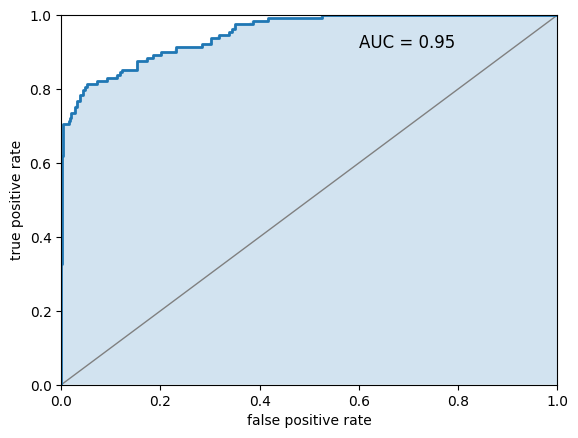

In [149]:
plt.figure()

plt.plot([0.0, 1.0], [0.0, 1.0], color='grey', linewidth=1)
plt.step(
    roc_curve_fpr,
    roc_curve_tpr,
    where='post',
    linewidth=2,
)
plt.fill_between(
    roc_curve_fpr,
    roc_curve_tpr,
    alpha=0.2,
)

plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

plt.text(
    0.60,
    0.95,
    f'AUC = {roc_auc:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
)

plt.savefig(f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-state-space-search-AUC.png')
plt.savefig(f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-state-space-search-AUC.pdf')

None

# Plot in sample accuracy

In [276]:
filename = f'decision_tree_model_by_min_samples_split_min_samples_leaf_AUC.csv'
df = pandas.read_csv(filename, index_col=0)

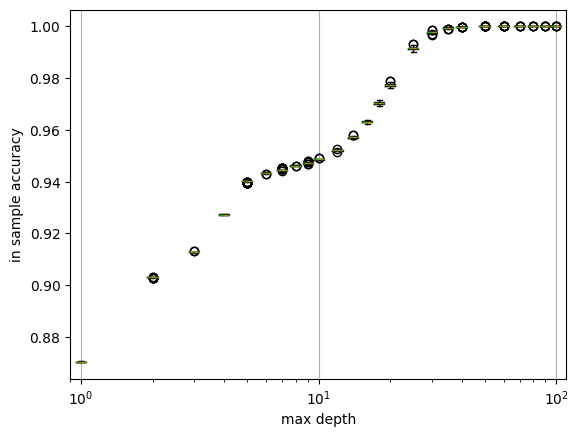

In [109]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_in_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.9, xmax=110)
plt.xlabel('max depth')
plt.ylabel('in sample accuracy')

plt.grid(axis='x')

plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-accuracy_in_sample_AUC.png')
plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-accuracy_in_sample_AUC.pdf')

None

# Plot out of sample accuracy

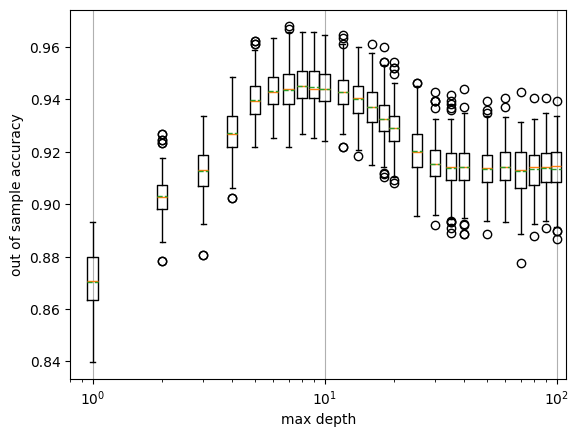

In [110]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):

    # if max_depth_ not in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                      10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                     100, 200]:
    #     pass #continue
    
    x.append(
        df[df['max_depth'] == max_depth_]['accuracy_out_of_sample']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=110)
plt.xlabel('max depth')
plt.ylabel('out of sample accuracy')

plt.grid(axis='x')

plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-accuracy_out_of_sample_AUC.png')
plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-accuracy_out_of_sample_AUC.pdf')

None

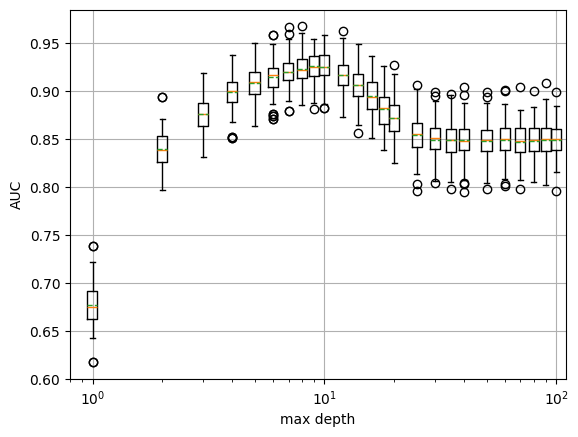

In [113]:
plt.figure()

df_select = df #df[df['min_samples_split'] == 2]

positions = []
x = []

for max_depth_ in sorted(df_select['max_depth'].unique()):

    # if max_depth_ not in [1, 2, 3, 4, 5, 6, 7, 8, 9,
    #                      10, 20, 30, 40, 50, 60, 70, 80, 90,
    #                     100, 200]:
    #     pass #continue
    
    x.append(
        df[df['max_depth'] == max_depth_]['auc']
    )
    positions.append(
        max_depth_
    )

plt.boxplot(
    x,
    positions=positions,
    orientation='vertical',
    meanline=True,
    showmeans=True,
    widths=[0.1 * position for position in positions],
)
plt.xscale('log')
plt.xlim(xmin=0.8, xmax=110)
plt.xlabel('max depth')
plt.ylabel('AUC')

plt.grid()

plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-AUC.png')
plt.savefig('decision_tree_model_by_min_samples_split_min_samples_leaf-AUC.pdf')

None

In [108]:
# make prediction - optimized using 400, 32 best value from state space search

max_depth = None
min_samples_split = 400
max_leaf_nodes = None
min_samples_leaf = 32
min_impurity_decrease = 0.0

training_data = all_training_data
test_data = all_training_data

(
    clf,
    feature_importances,
    accuracy_in_sample,
) = decision_tree_model_train(
    training_data,
    decision_tree_columns,
    max_depth,
    min_samples_split,
    max_leaf_nodes,
    min_samples_leaf,
    min_impurity_decrease,
)

accuracy_out_of_sample = decision_tree_model_test(
    clf,
    test_data,
    decision_tree_columns,
)

auc_ = decision_tree_model_test_AUC(
    clf,
    test_data,
    decision_tree_columns,
)
auc_list.append(auc_)

data_predict = decision_tree_model_predict(
   clf,
   data_test_copy,
   decision_tree_columns,
   decision_tree_columns_with_id,
)

decision_tree_model_predict_write_to_csv(
   data_predict,
   f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-state-space-search_400_32.csv'
)

auc_

0.9548030030074693

In [109]:
# plot in sample, out of sample, auc, ROC + AUC

In [117]:
# make prediction - no max depth, min samples split 30, min samples leaf 4
    
max_depth = None
min_samples_split = 30
max_leaf_nodes = None
min_samples_leaf = 4
min_impurity_decrease = 0.0

auc_list = []
    
for i in range(k):
    test_index = folds[i]
    train_index = numpy.concatenate([folds[j] for j in range(k) if j != i])
        
    training_data = all_training_data.loc[train_index]
    test_data = all_training_data.loc[test_index]
    #training_data = all_training_data
    #test_data = all_training_data
    
    (
        clf,
        feature_importances,
        accuracy_in_sample,
    ) = decision_tree_model_train(
        training_data,
        decision_tree_columns,
        max_depth,
        min_samples_split,
        max_leaf_nodes,
        min_samples_leaf,
        min_impurity_decrease,
    )
    
    accuracy_out_of_sample = decision_tree_model_test(
        clf,
        test_data,
        decision_tree_columns,
    )
    
    auc_ = decision_tree_model_test_AUC(
        clf,
        test_data,
        decision_tree_columns,
    )
    auc_list.append(auc_)
    
    #data_predict = decision_tree_model_predict(
    #    clf,
    #    data_test_copy,
    #    decision_tree_columns,
    #    decision_tree_columns_with_id,
    #)
    
    #decision_tree_model_predict_write_to_csv(
    #    data_predict,
    #    f'decision_tree_model_one_hot_encoder_2_clean_code-2-AUC-2-min_samples_split_30-min_samples_leaf_4.csv'
    #)
    
    #auc_

(array([ 2.,  3.,  3., 11., 25., 21., 14., 13.,  6.,  2.]),
 array([0.85773975, 0.86722621, 0.87671267, 0.88619913, 0.89568558,
        0.90517204, 0.9146585 , 0.92414496, 0.93363142, 0.94311787,
        0.95260433]),
 <BarContainer object of 10 artists>)

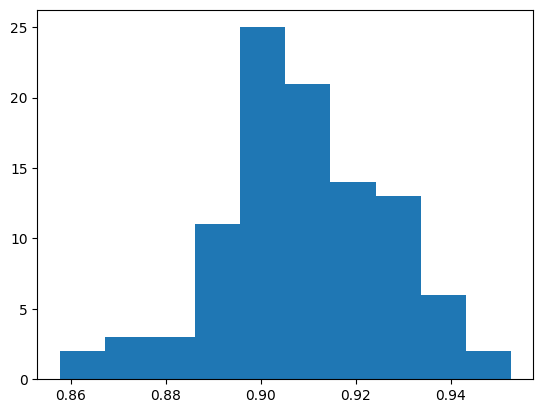

In [118]:
plt.figure()

plt.hist(auc_list)

None

# Plot the distribution of `predict_proba` values

In [153]:
data_predict = decision_tree_model_predict(
    clf,
    data_test_copy,
    decision_tree_columns,
    decision_tree_columns_with_id,
)

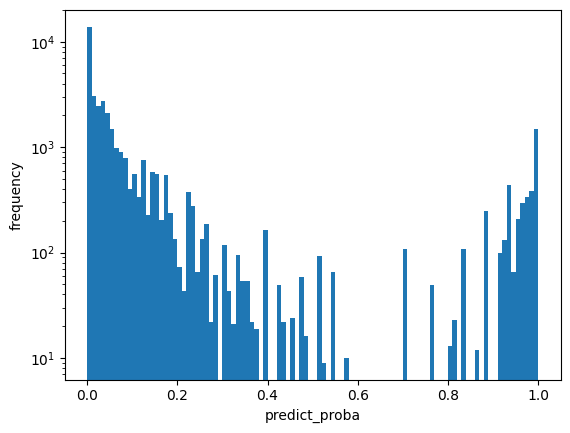

In [155]:
plt.figure()
plt.hist(data_predict['loan_status'], bins=100)
plt.yscale('log')

plt.xlabel('predict_proba')
plt.ylabel('frequency')

plt.savefig('state-space-search-predict-proba.pdf')

None